In [15]:
import numpy as np
import matplotlib.pyplot as plt
# import alphashape
from matplotlib.path import Path
from scipy.spatial import ConvexHull
import ot

In [16]:
def generate_mu(clusters):
    s = 0
    for cluster in clusters:
        s += cluster.shape[0]
    return [1/s]*s

def dist(point1, point2):
    if point1.shape[0] == 2:
        return (point1[0] - point2[0])**2 + (point1[1] - point2[1])**2
    if point1.shape[0] == 3:
        return (point1[0] - point2[0])**2 + (point1[1] - point2[1])**2 + (point1[2] - point2[2])**2
    
def generate_d_graph_1(points, adj):
    n = points.shape[0]
    max_dist = 10.0
    d = np.zeros((n, n)) + max_dist
    for src in range(n):
        not_visited = np.array([True] * n)
        shortest_path = np.array([max_dist] * n)
        shortest_path[src] = 0
        while not_visited.sum() > 0:
#             print(shortest_path)
#             print(not_visited)
            current_min = np.argmin((shortest_path - max_dist)*(not_visited))
            if shortest_path[current_min] >= max_dist:
                break
            if not_visited[current_min] == False:
                break
            for neigh in adj[current_min]:
                dis = math.sqrt(dist(points[current_min], points[neigh]))
#                 print(current_min, neigh, dis)
                if shortest_path[current_min] + dis < shortest_path[neigh]:
                    shortest_path[neigh] = shortest_path[current_min] + dis
            not_visited[current_min] = False
        for i in range(n):
            d[src, i] = shortest_path[i]
    return d

def generate_d_graph(clusters, adjs):
    s = 0
    for cluster in clusters:
        s += cluster.shape[0]
    n = s
    ix = np.zeros((n,n))
    d = np.zeros((n,n))
        
    s = 0
    for k in range(len(clusters)):
        dc = generate_d_graph_1(clusters[k], adjs[k])
        for i in range(clusters[k].shape[0]):
            for j in range(clusters[k].shape[0]):
                ix[i+s, j+s] = 1
                d[i+s, j+s] = dc[i, j]**2
        s += clusters[k].shape[0]
    return d, ix
            
                
    

def generate_d(clusters):
    s = 0
    for cluster in clusters:
        s += cluster.shape[0]
    n = s
    ix = np.zeros((n,n))
    d = np.zeros((n,n))
        
    s = 0
    for cluster in clusters:
        for i in range(cluster.shape[0]):
            for j in range(cluster.shape[0]):
                ix[i+s, j+s] = 1
                d[i+s, j+s] = dist(cluster[i], cluster[j])
        s += cluster.shape[0]
    return d, ix

In [17]:
def gamma(mu, d_x, i_x, d_y):
#     print(mu.shape)
#     print(d_x.shape)
#     print(i_x.shape)
#     print(d_y.shape)
    return np.matmul(np.matmul(i_x, mu), d_y*d_y) - 2*np.matmul(np.matmul(d_x, mu), d_y)

In [18]:
def cost(gamma, mu):
    if mu.shape[0] != gamma.shape[0]:
        print(mu.shape)
        print(gamme.shape)
    s = 0
    for i in range(mu.shape[0]):
        for j in range(mu.shape[1]):
            s += mu[i,j] * gamma[i,j]
    return s

In [19]:
import math

def read(file_path):
    vertices = []
    faces = []
    with open(file_path) as f:
        for line in f:
            if line[0] == "v" and line[1] == " ":
                vertex = list(map(float, line[2:].strip().split()))
                vertices.append(vertex)
            elif line[0] == "f":
                face = line[2:].strip().split()
                if len(face) != 3:
                    print(face)
                    continue
                for i in range(len(face)):
                    face[i] = int(face[i].split('/')[0])
                faces.append((face[0], face[1], face[2]))
    #             face = list(map(int, line[2:].strip().split()))
                faces.append(face)
    vertices = np.array(vertices)
    return vertices, faces

vertices, faces = read('Data/puzz/pikachu/Pikachu_lfoot.obj')

def get_edges(vertices, faces):
    adj = []
    for i in range(vertices.shape[0]):
        adj.append([])
    for i in range(len(faces)):
        for j in range(3):
            k = (j + 1)%3
            v1 = faces[i][j] - 1
            v2 = faces[i][k] - 1
            adj[v1].append(v2)
            adj[v2].append(v1)
    for i in range(vertices.shape[0]):
        adj[i] = list(np.unique(np.array(adj[i])))
    return adj

def get_coords(vertices, face):
    return [vertices[face[0] - 1], vertices[face[1] - 1], vertices[face[2] - 1]]

def compute_area(coords):
    c = coords
    a = np.linalg.norm(c[0] - c[1])
    b = np.linalg.norm(c[2] - c[1])
    c = np.linalg.norm(c[0] - c[2])
    p = (a+b+c)/2
    return math.sqrt(p * (p-a) * (p-b) * (p-c))

def get_area_array(vertices, faces):
    s = [0]
    for i in range(len(faces)):
        c = get_coords(vertices, faces[i])
        area = compute_area(c)
        s.append(s[-1] + area)
    s = np.array(s)
    return s

def get_point(vertices, faces, areas):
    x = np.random.uniform()
    i = np.searchsorted(areas, x*areas[-1])
    face = faces[i - 1]
    c = get_coords(vertices, face)
    s = np.random.uniform()
    t = np.random.uniform()
    if s + t > 1:
        s = 1 - s
        t = 1 - t
    p = (c[2] - c[0]) * s + (c[1] - c[0]) * t + c[0]
    return p

points = []
s = get_area_array(vertices, faces)
print(s[-1])
for i in range(2000):
    p = get_point(vertices, faces, s)
    points.append(p)
points = np.array(points)
print(points)
print(get_edges(vertices, faces))

149.81240183523218
[[ 9.38983542  4.51868763  1.71744446]
 [ 6.51660118  1.5751482   3.39660492]
 [ 8.08122365  2.89142109 -0.23014085]
 ...
 [ 7.70781096  1.0467032  -0.23683738]
 [ 9.01432967  1.7508968   2.44015412]
 [ 7.68916738  2.26397723  4.83895572]]
[[1, 751], [0, 751], [222, 400], [514, 518], [164, 678, 745], [398, 524], [227, 862], [631, 765], [223, 228], [240, 901], [234, 239], [13, 526, 761, 860], [141, 207], [11, 860], [231, 508], [866, 902], [528, 763], [236, 246], [204, 237], [250, 530, 680], [244, 505], [23, 448], [25, 681], [21, 443, 448], [251, 535], [22, 257, 536, 681], [159, 449], [252, 502], [258, 683, 868], [501, 534], [498, 539], [262, 263], [266, 543], [685, 846], [158, 264, 454, 540], [542, 544], [265, 458, 541], [39, 460, 545, 920], [40, 41], [37, 44, 169, 545, 547, 872, 920], [38, 41, 268, 546, 869, 871], [38, 40, 268, 269], [272, 276], [277, 667, 904], [39, 169, 270, 271, 634, 770, 872], [550, 772], [273, 280, 437, 771], [549, 687], [52, 279, 671, 844], [28

In [20]:
def read_off_file(filepath):
    """
    Reads an OFF file and extracts vertex and face data.

    Args:
        filepath (str): The path to the OFF file.

    Returns:
        tuple: A tuple containing two lists:
               - vertices (list of lists): Each inner list represents a vertex [x, y, z].
               - faces (list of lists): Each inner list represents a face,
                                       containing vertex indices.
    """
    vertices = []
    faces = []

    with open(filepath, 'r') as f:
        # Read the first line to check for 'OFF' keyword
        first_line = f.readline().strip()
        if first_line != 'OFF':
            raise ValueError("Invalid OFF file: Missing 'OFF' keyword.")

        # Read the second line for number of vertices, faces, and edges
        num_vertices, num_faces, num_edges = map(int, f.readline().split())

        # Read vertices
        for _ in range(num_vertices):
            vertex_coords = list(map(float, f.readline().split()))
            vertices.append(vertex_coords)

        # Read faces
        for _ in range(num_faces):
            face_data = list(map(int, f.readline().split()))
            # The first element of face_data is the number of vertices in the face
            # The remaining elements are the vertex indices
            faces.append(face_data[1:])

    vertices = np.array(vertices)
    return vertices, faces

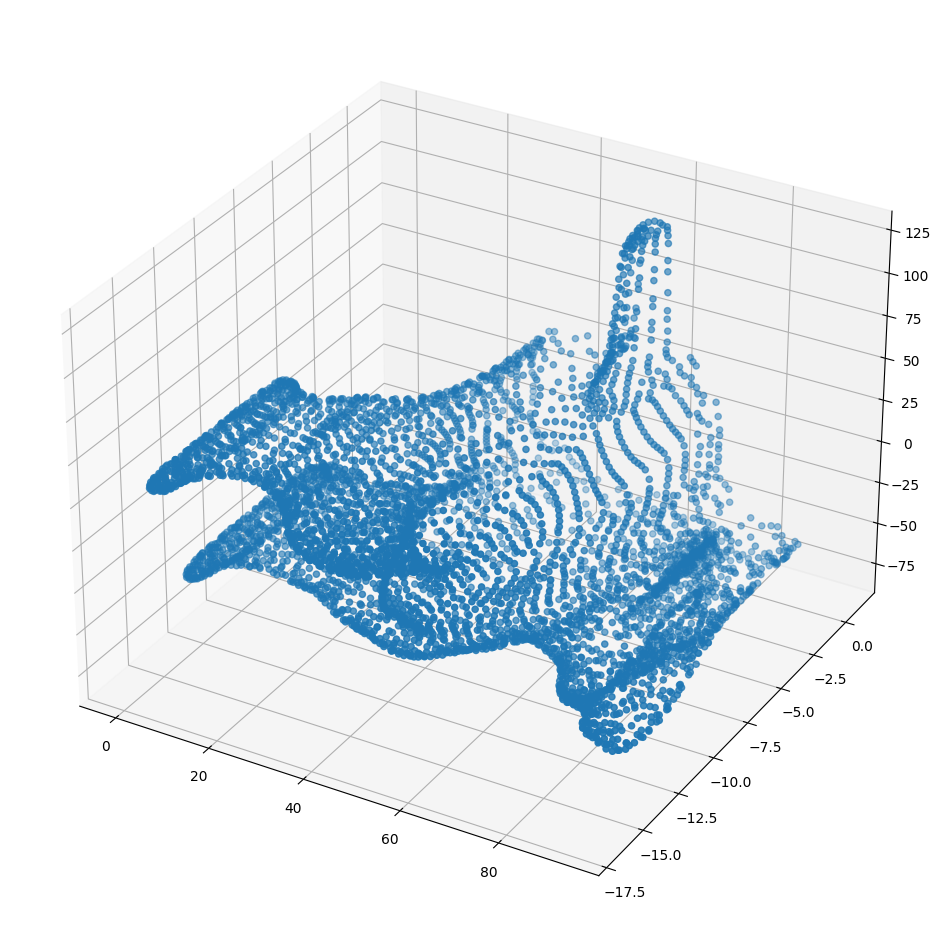

In [117]:
vertices_p, faces = read_off_file('Data/partial_off/SGP_dataset_off/cuts/cat0_partial1.off')
points_x = [[],[]]
for i in range(vertices_p.shape[0]):
    points_x[0].append(vertices_p[i])
points_x[0] = np.array(points_x[0])

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
# ax.scatter(vertices[:,2], vertices[:,0], vertices[:,1], alpha=0.01)
ax.scatter(points_x[0][:,2], points_x[0][:,0], points_x[0][:,1])
plt.show()

2269391038.4989667
47638.125891967735


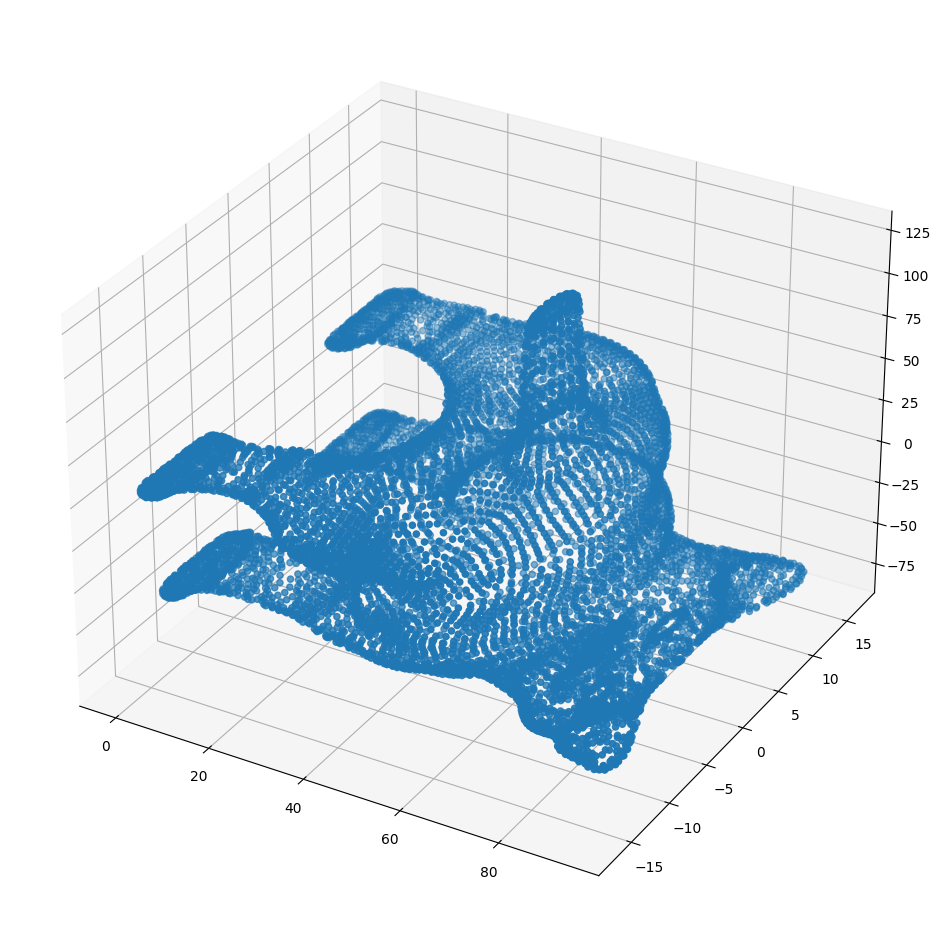

In [118]:
vertices, faces = read_off_file('Data/partial_off/SGP_dataset_off/null/cat0.off')
s = get_area_array(vertices, faces)
print(sum(s))
sqrtareaY = math.sqrt(sum(s))
print(sqrtareaY)
points_y = []
for i in range(vertices.shape[0]):
    points_y.append(vertices[i])
points_y = np.array(points_y)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
# ax.scatter(vertices[:,2], vertices[:,0], vertices[:,1], alpha=0.01)
ax.scatter(points_y[:,2], points_y[:,0], points_y[:,1])
plt.show()

In [119]:
rm = []
rmfile = open('Data/partial_off/SGP_dataset_off/null/cat0.remesh')
lines = rmfile.readlines()
for line in lines:
    rm.append(int(line.strip()) - 1)
rmfile.close()

In [120]:
gt = []
gtfile = open('Data/partial_off/SGP_dataset_off/cuts/cat0_partial1.gt')
for i in range(points_x[0].shape[0]):
    gt.append(int(gtfile.readline().strip()) - 1)
#     print(gtfile.readline())
#     break
gtfile.close()

In [121]:
len(gt)

5110

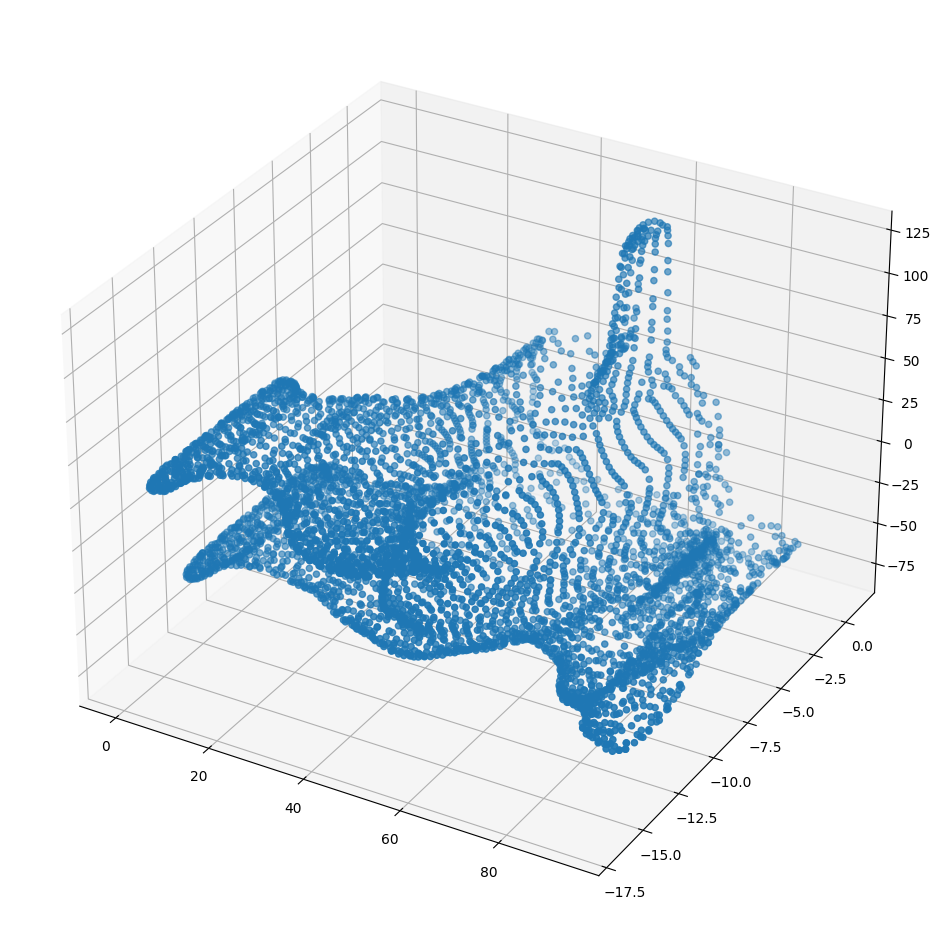

In [122]:
points_c = []
marks = [0] * points_y.shape[0]
for i in range(points_x[0].shape[0]):
    points_c.append(points_y[rm[gt[i]]])
    marks[rm[gt[i]]] = 1
points_c = np.array(points_c)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(points_c[:,2], points_c[:,0], points_c[:,1])
plt.show()

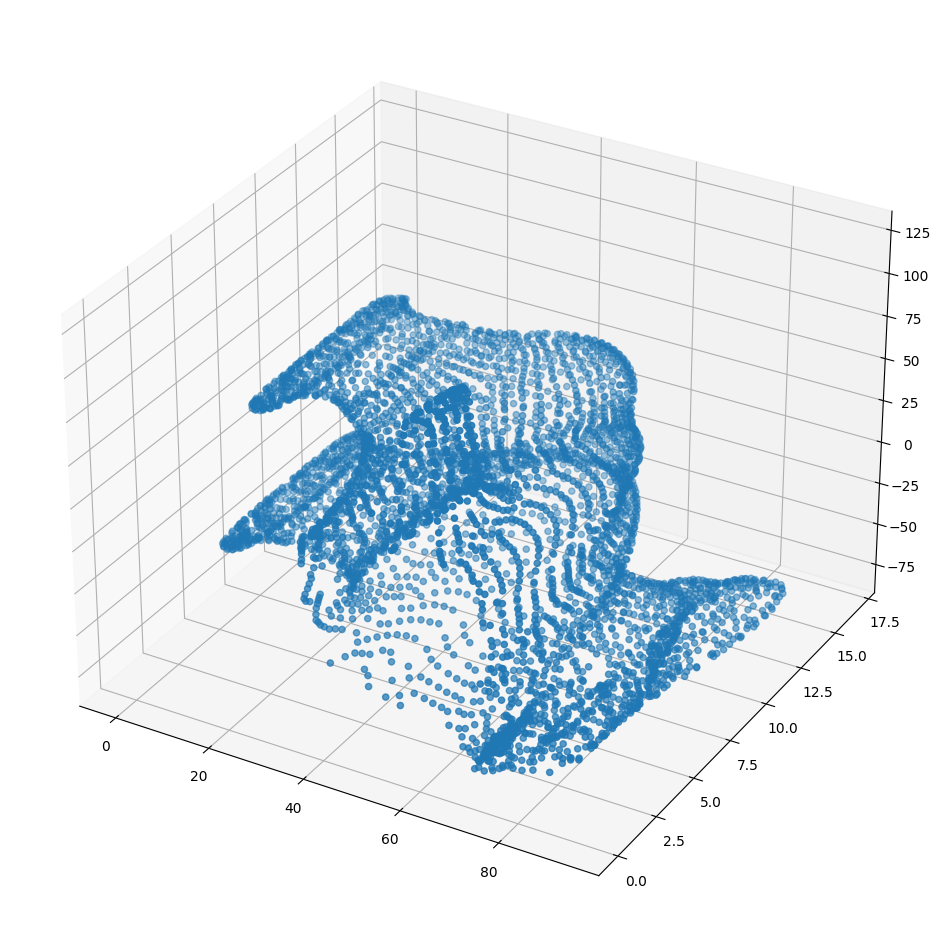

In [123]:
for i in range(points_y.shape[0]):
    if marks[i] == 1:
        continue
    if points_y[i][0]< 0 :
        continue
    points_x[1].append(points_y[i])
points_x[1] = np.array(points_x[1])

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
# ax.scatter(vertices[:,2], vertices[:,0], vertices[:,1], alpha=0.01)
ax.scatter(points_x[1][:,2], points_x[1][:,0], points_x[1][:,1])
plt.show()

In [124]:
d_x, i_x = generate_d(points_x)
mu_x = [1/d_x.shape[0]] * d_x.shape[0]
mu_x = np.array(mu_x)

In [125]:
d_y, i_y = generate_d([points_y])
mu_y = [1/len(points_y)] * len(points_y)
mu_y = np.array(mu_y)

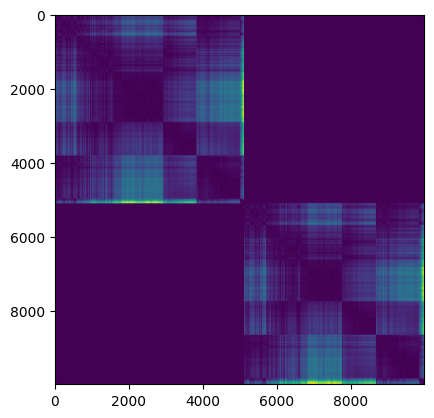

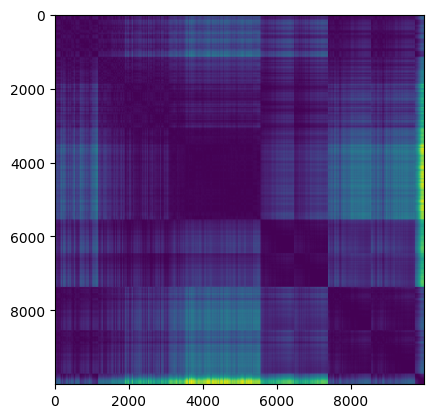

In [126]:
plt.imshow(d_x)
plt.show()
plt.imshow(d_y)
plt.show()

C:\Users\artaj\AppData\Local\Programs\Python\Python310\lib\site-packages\ot\bregman.py:535: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


#####
0
5.381582341896359e-09
0.8340649126365132
0.9999999999999922


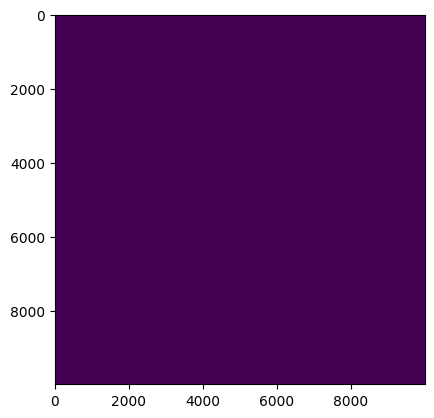

313.2837481498718
#####
1
5.159137751180756e-09
0.7758572744963731
0.9999999999999974


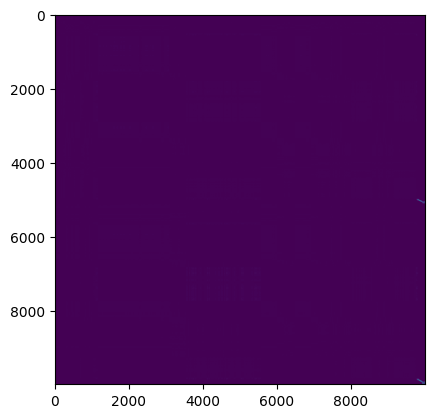

293.5635619163513
#####
2
3.5347985807305764e-09
0.44370533516125227
0.9999999999999802


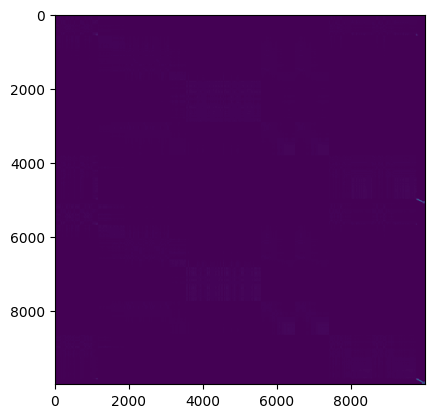

301.5219204425812
#####
3
3.4500064287682662e-09
0.1370856169245677
0.9999999999999847


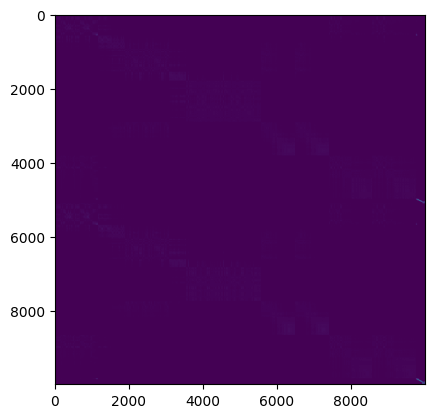

334.97756266593933
#####
4
3.4428136363813364e-09
0.04241193699517457
0.9999999999999869


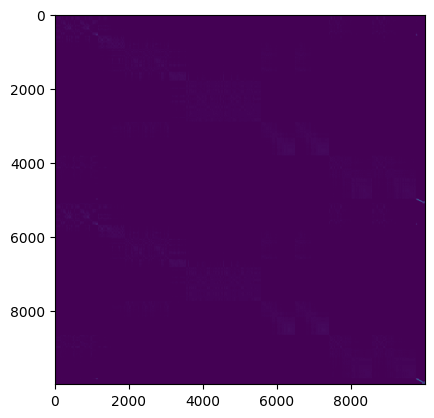

320.2775721549988
#####
5
3.441504231419341e-09
0.023258889044528858
0.9999999999999851


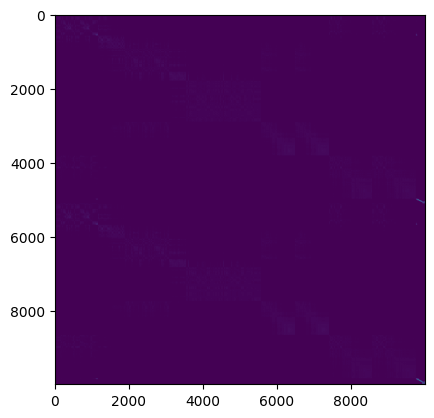

325.35564732551575
#####
6
3.4411141356377424e-09
0.013505136847466669
0.9999999999999896


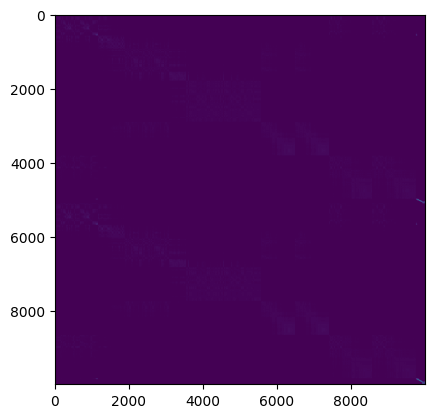

315.8866364955902
#####
7
3.4410056512313094e-09
0.009419860881200663
0.9999999999999833


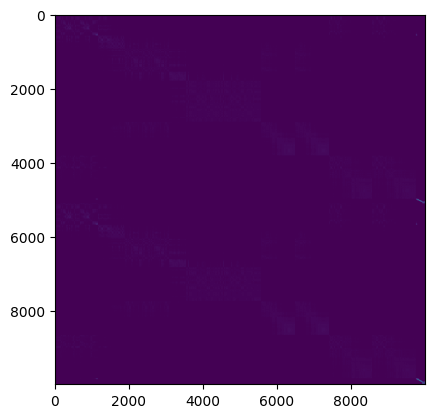

329.50553727149963
#####
8
3.440952507035469e-09
0.005751013591230097
0.9999999999999918


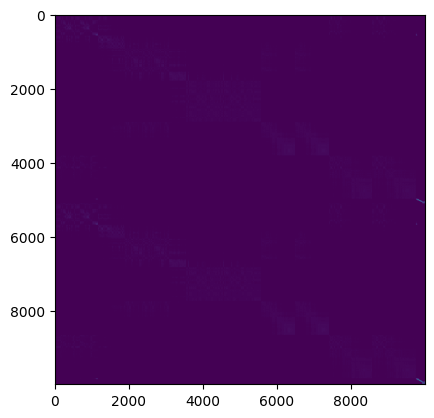

305.44837069511414
#####
9
3.4409216963910857e-09
0.004013052311780336
0.9999999999999865


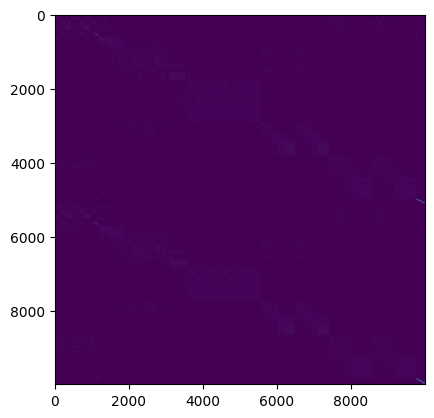

279.0689969062805


In [127]:
eta = 1
import time
alpha = 1e6
cur_mu = np.outer(mu_x, mu_y)
dif = []
costs = []
mus = []
for i in range(10):
    t = time.time()
    c = gamma(cur_mu, d_x, i_x, d_y)
    c_o = c
    c -= c.min()
    c = (c**eta) * (cur_mu**(1-eta))
    
#     plt.imshow(c)
#     plt.show()
#     print(c)
    
    
    k = 1/c.sum() *c.shape[0] * c.shape[1]
    c = c*k
    alpha1=alpha*k
    mu = ot.sinkhorn(mu_x, mu_y, c, alpha1)
    print('#####')
    print(i)
    print(k)
    print(abs(mu - cur_mu).sum())
    print(mu.sum())
    dif.append(abs(mu - cur_mu).sum())
    costs.append(cost(c_o, cur_mu))
    plt.imshow(cur_mu)
    plt.show()
#     plt.imshow(c)
    plt.show()
    cur_mu = mu
#     if dif[-1] < 1e-4:
#         cur_mu = np.random.rand(mu.shape[0], mu.shape[1])
#         cur_mu /= cur_mu.sum()
    mus.append(cur_mu)
    print(time.time() - t)

In [128]:
len(mus)

10

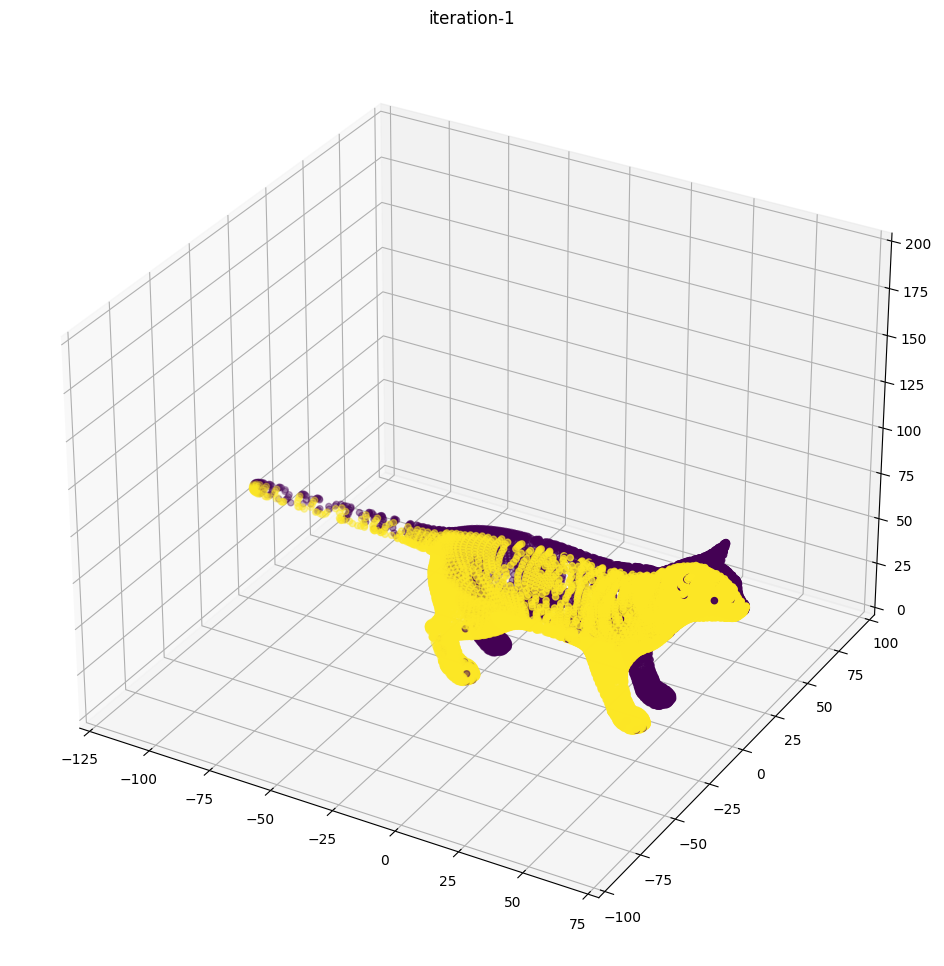

In [129]:
# for k in range(len(mus)):
for k in [-1]:
    mu = mus[k]
    
    thresh = 0
    labels = []
    tots = []
    for i in range(points_y.shape[0]):
        tot = [0]*2
        for j in range(mu.shape[0]): 
            if mu[j, i] > thresh:
                tot[marks[i]] += mu[j,i]
        tots.append(tot)
        labels.append(np.argmax(tot))
    tots = np.array(tots)
    
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(-points_y[:,1], points_y[:,0], points_y[:,2], c=labels)
    ax.set_title('iteration' + str(k))
    ax.set_xlim(-125,75)
    ax.set_ylim(-100, 100)
    ax.set_zlim(0,200)
#     plt.savefig('cat0-res.png')
        
    plt.show()

In [130]:
mu.shape

(9989, 10000)

In [131]:
points_y.shape

(10000, 3)

In [144]:
dists = []
mesh = mr.loadMesh('Data/partial_off/SGP_dataset_off/null/cat0.off')
for j in range(points_x[0].shape[0]):
    maxi = None
    maxx = 0
    for i in range(points_y.shape[0]):
        if mus[-1][j, i] > maxx:
            maxx = mus[-1][j, i]
            maxi = i
#     print(points_y[maxi])
#     print(points_y[rm[gt[j]]])
#     print(np.linalg.norm(points_y[maxi] - points_y[rm[gt[j]]]))
#     break
#     dists.append(np.linalg.norm(points_y[maxi] - points_y[rm[gt[j]]]) / sqrtareaY)
    p1 = mr.Vector3f(points_y[maxi][0], points_y[maxi][1], points_y[maxi][2])
    p2 = mr.Vector3f(points_y[rm[gt[j]]][0], points_y[rm[gt[j]]][1], points_y[rm[gt[j]]][2])
    path = mr.computeGeodesicPath(mesh, mr.findProjection(p1, mesh).mtp, mr.findProjection(p2, mesh).mtp)
    l = 0
    prev = None
    for p in path:
        if prev is None:
            continue
        pc = mesh.edgePoint(p)
        l += ((pc.x - prev.x)**2 + (pc.y - prev.y)**2 + (pc.z - prev.z)**2)**(1/2)
        prev = pc
    if path.size() > 0:
        dists.append(l / sqrtareaY)
    else:
        dists.append(np.linalg.norm(points_y[maxi] - points_y[rm[gt[j]]]) / sqrtareaY)
        


In [145]:
((0.489578 - -0.294345)**2 + (37.576 - 35.685963)**2 + (38.3647 - 36.86253 )**2)**(1/2)

2.5383636146537394

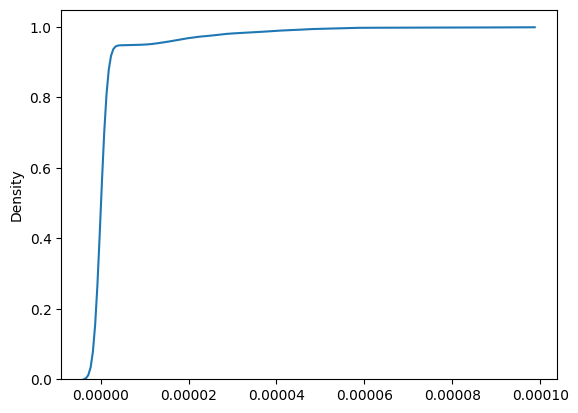

In [147]:
import seaborn as sns

sns.kdeplot(data = dists, cumulative = True, label = "X1")
# plt.savefig('cat-error.svg')
plt.show()

In [135]:
# import meshlib.mrmeshpy as mr
# mesh = mr.loadMesh('Data/partial_off/SGP_dataset_off/null/cat0.off')
# path = mr.computeGeodesicPath(mesh, mr.findProjection(mr.Vector3f(points_y[0][0], points_y[0][1], points_y[0][2] ), mesh).mtp, mr.findProjection(mr.Vector3f(points_y[100][0], points_y[100][1], points_y[100][2] ), mesh).mtp)

# for p in path:
#     print(p)
#     pc = mesh.edgePoint(p)
#     print(pc.x,pc.y,pc.z)
# print(path.size())
# path.x

In [136]:
# points_y[0][0], points_y[0][1], points_y[0][2] 